In [1]:
%matplotlib inline

In [33]:
import os
import io
import sys
import six
import math
from random import shuffle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix,dok_matrix, lil_matrix
from sklearn.feature_extraction.text import CountVectorizer,  TfidfTransformer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cross_validation import train_test_split

from common_lib.lyrics_database import LyricsDatabase

In [3]:
lyrics_dir = '/data1/nlp-data/ghostwriter/data/top-selling-rappers-cleaned-json'
ld = LyricsDatabase(lyrics_dir)

In [4]:
artists = ld.get_artists_names()
print(len(artists))

14


In [5]:
def transform_lyric_to_doc(lyric):
    result_text = io.StringIO()
    
    is_skip = lambda s : s == '<startVerse>' or s == '<endVerse>' or s == '<endLine>'
    
    for token in lyric:
        if is_skip(token):
            continue
            
        if isinstance(token, six.string_types):
            result_text.write(' ')
            result_text.write(token)
        else:
            for token2 in token:
                if is_skip(token2):
                    continue
                result_text.write(' ')
                result_text.write(token2)
        
    
    return result_text.getvalue()

In [6]:
artist_lyrics = {}
for a in artists:
    lyrics = ld.get_lyrics_from_artist(a)
    docs = [transform_lyric_to_doc(l) for l in lyrics]
    artist_lyrics[a] = docs
    print(a, len(docs))

kanye_west 147
drake 144
gza 77
fabolous 190
sage_francis 108
eminem 253
too_$hort 237
jay 216
dmx 174
lil_wayne 312
notorious_b.i.g. 75
aesop_rock 109
2pac_makaveli 102
kool_keith 336


In [7]:
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix_train = tfidf_vectorizer.fit_transform(docs)
# cosine_similarity(tfidf_matrix_train[0:1], tfidf_matrix_train)

In [8]:
train_artist = 'fabolous'
test_artist = 'kanye_west'

train_artist_lyrics = artist_lyrics[train_artist]
test_artist_lyrics = artist_lyrics[train_artist]

# split to train-test data 
train_data, test_data_same = train_test_split(train_artist_lyrics, test_size=0.1, random_state=43)

# add lyrics from another artist to test_data
shuffle(test_artist_lyrics)
test_data_another = test_artist_lyrics[0:len(test_data_same)]

print(len(train_data), len(test_data_same), len(test_data_another))

171 19 19


TF-IDF from sklearn
==========

In [9]:
data = []
data.extend(train_data)
data.extend(test_data_same)
data.extend(test_data_another)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_train = tfidf_vectorizer.fit_transform(data)
# cosine_similarity(tfidf_matrix_train[0:1], tfidf_matrix_train)
tfidf_matrix_train

<209x8264 sparse matrix of type '<class 'numpy.float64'>'
	with 46969 stored elements in Compressed Sparse Row format>

In [10]:
test_len = len(test_data_same)
test_same_idx_start = len(train_data)
test_anoter_idx_start = len(train_data) + test_len
test_idx_end = test_anoter_idx_start + test_len
print(test_same_idx_start, test_anoter_idx_start, test_idx_end)

171 190 209


In [53]:
results_tfidf = {}
for i in range(test_same_idx_start, test_anoter_idx_start):
    similarities = cosine_similarity(tfidf_matrix_train[i], tfidf_matrix_train)
    results_tfidf['same_' + str(i)] = similarities.mean()
for i in range(test_anoter_idx_start, test_idx_end):
    similarities = cosine_similarity(tfidf_matrix_train[i], tfidf_matrix_train)
    results_tfidf['another_' + str(i)] = similarities.mean()
    
print(len(results_tfidf))

38


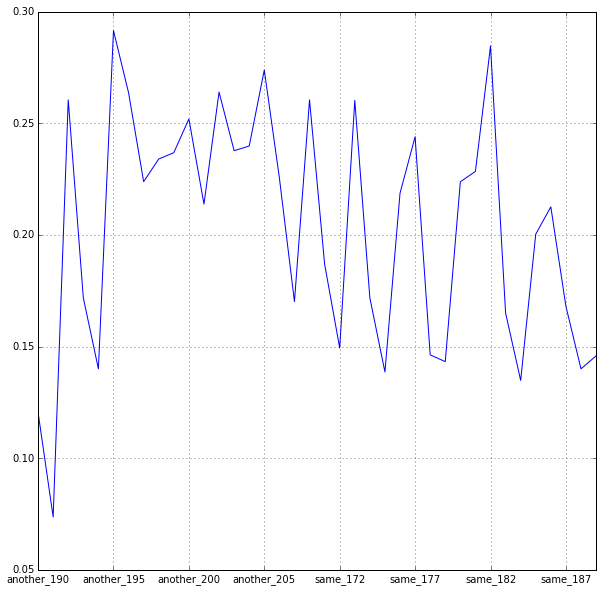

In [54]:
pd.Series(results_tfidf).plot(figsize=(10,10))

logIDF from the paper
===========

In [31]:
data = []
data.extend(train_data)
data.extend(test_data_same)
data.extend(test_data_another)

N = len(data)
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(data).tocsc()

In [40]:
weight_data = dok_matrix(count_data.shape)

for i in range(0, weight_data.shape[0]):
    for j in range(0, weight_data.shape[1]):
        nj = count_data[:,j].nnz
        w = count_data[i,j] * math.log(N/nj)
        if w != 0:
            weight_data[i,j] = w

In [56]:
results_paper = {}
for i in range(test_same_idx_start, test_anoter_idx_start):
    similarities = cosine_similarity(weight_data[0:test_same_idx_start-1,], weight_data[i,])
    results_paper['same_' + str(i)] = similarities.mean()
for i in range(test_anoter_idx_start, test_idx_end):
    similarities = cosine_similarity(weight_data[0:test_same_idx_start-1,], weight_data[i,])
    results_paper['another_' + str(i)] = similarities.mean()
    
print(len(results_paper))

38


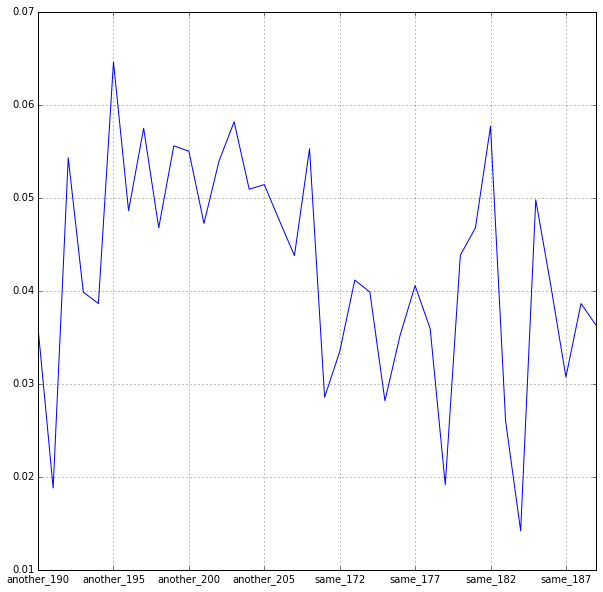

In [57]:
pd.Series(results_paper).plot(figsize=(10,10))